<a href="https://colab.research.google.com/github/SJharbade/mlProjects/blob/main/AdvanceGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Advance GAN

# Importing Libraries

import torch, torchvision, os, PIL, pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
def show(tensor, num =25, wandbactive =0, name =''):
  data = tensor.detach().cpu
  #grid = make_grid(data[:num], nrow = 5).permute(1,2,0)
  grid = make_grid(tensor, nrow = 5).permute(1,2,0)

  # Optional
  #if(wandb == 0 and wandbact ==0):
  #  wandb.log({name: wandb.Image(grid.numpy().clip(0,1))})

  plt.imshow(grid.clip(0,1))
  plt.show()

  # Hyperparameters and general parameters
n_epochs = 10000
batch_size = 128
lr = 1e-4
z_dim = 200 ### Latent space ( the hidden layer that contains the latent variables that are used to generate the outputs)  Dimensionality
device = 'cuda' ### ie GPU

cur_step =0
crit_cycles =5 ### critic cycle 5 here denotes, every one generator there will be 5 times execution of critics so that critic cycle doen't overwhelm with generator
gen_losses =[]
crit_losses = []
show_steps =35 # every n, here 35, steps it will show progress
save_steps = 35 ### THis is check point and is required either if training is going on too longs like for days, it save the models and when training restarts it restarts from the check points

wandbact =0 ### THiS is optional parameter


In [ ]:
### Generator Model

class Generator(nn.Module):
  def __init__(self, z_dim =64, d_dim = 16): # z_dim will be replaced with the value 200 that we decalred earlier and d_dim is for Convolution network
    super(Generator, self).__init__()  ## initialize the class with call to parent
    self.z_dim = z_dim  ### initialize new valriable to store data for latent space

    self.gen = nn.Sequential(
        ## ConvTranspose2d: in_channels, out_channels, kernel_size, stride =1, padding =0, channels here is color of image
        ## Calculating new width and height : (n -1)*stride -2*padding +ks
        ## n = width or height
        ## ks = Kernel size, Kernel is size of Matrix for example for metrics 4 x 4 Kernel = 4
        ## We begin with a 1 x 1 image with z_dim number of channels (200)
        nn.ConvTranspose2d(z_dim, d_dim * 32, 4,1,0), ### So here we are passing image of 200 channels(color), d_dim is nothin a variable that is initilize to 16 and
                                                      ### act as out channels(colors)
                                                      ## So overall we are passing 4x4 image with (ch: 200, 512)
        nn.BatchNorm2d(d_dim *32),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim *32, d_dim * 16, 4, 1, 0), ## So here we are passing 16x16 image with (ch: 512, 256)
        nn.BatchNorm2d(d_dim *16),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim *16, d_dim * 8, 4, 1, 1), ## So here we are passing 32x32 image with (ch: 512, 256)
        nn.BatchNorm2d(d_dim *8),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim *8, d_dim * 4, 4, 1, 1),  ## So here we are passing 64x64 image with (ch: 64, 32)
        nn.BatchNorm2d(d_dim *4),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim *4, d_dim * 2, 4, 1, 1), ## So here we are passing 4x4 image with (ch: 200, 512)
        nn.BatchNorm2d(d_dim *2),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim *2, 3, 4, 1, 1), ## So here output channel is 3 because we need image in RGB color
        ## Don't need batch norm in last layer
        nn.Tanh() ## produce result in the range -1 to 1

    )
  def forward(self,noise):
    x =noise.view(len(noise),self.z_dim,1,1)
    return self.gen(x)

def gen_noise(num,z_dim,device = 'cuda'):
    return torch.rand(num,z_dim, device = device)

In [ ]:
### Critic Model
# Conv2d: in_channels, out_channels, kernerl_size, stride =1, padding = 0
# New Width and Height: (n+2 * Pad - ks)/ stride +1

class Critic(nn.Module):
  def __init__(self, d_dim = 16):
    super(Critic, self).__init__()
    self.crit = nn.Sequential(
   # Conv2d: in_channels, out_channels, kernerl_size, stride =1, padding = 0
   # New Width and Height: (n+2 * Pad - ks)/ stride +1
   # Here we go from larger size image,128x128, to small size image 1x1

   nn.Conv2d(3, d_dim, 4, 2, 1),  # Size of image will be 64 x 64 with Channel(3, 16)
   nn.InstanceNorm2d(d_dim),
   nn.LeakyReLU(0.2),

   nn.Conv2d(d_dim, d_dim*2, 4, 2, 1),    # Size of image will be 32 x 32 with Channel(16, 32)
   nn.InstanceNorm2d(d_dim*2),
   nn.LeakyReLU(0.2),

   nn.Conv2d(d_dim*2, d_dim*4, 4, 2, 1),   # Size of image will be 16 x 16 with Channel(32,64)
   nn.InstanceNorm2d(d_dim*4),
   nn.LeakyReLU(0.2),

   nn.Conv2d(d_dim*4, d_dim*8, 4, 2, 1),   # Size of image will be 8 x 8 with Channel(64,128)
   nn.InstanceNorm2d(d_dim*8),
   nn.LeakyReLU(0.2),

   nn.Conv2d(d_dim*8, d_dim*16, 4, 2, 1),  # Size of image will be 4 x 4 with Channel(128, 256)
   nn.InstanceNorm2d(d_dim*16),
   nn.LeakyReLU(0.2),

   nn.Conv2d(d_dim*16, 1 , 4, 1, 0)   # Size of image will be 1 x 1 with Channel(256 , 1), critic will output only 1 value

  )

  def forward(self,image):
    crit_pred = self.crit(image)
    return crit_pred.view(len(crit_pred), -1 )

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import gdown, zipfile

path= '/content/gdrive/MyDrive/Data/img_align_celeba.zip'
# This is obtained by finding the celeba file in the folder option on the left      # hand of the screen
# and right-click copy path. You will find it in the same structure as your drive    # organization

dir_path='data/celba'
# Same as from the lecture video

if not os.path.exists(dir_path):
  os.makedirs(dir_path)

with zipfile.ZipFile(path, 'r') as ziphandler:
  ziphandler.extractall(dir_path)

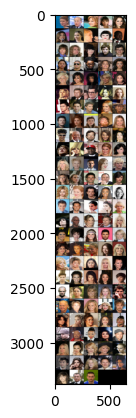

In [ ]:
# dataset, dataloader, gen, crit,test datasets
path1 = 'data/celba/img_align_celeba'
class Dataset(Dataset):
  def __init__(self,path, size =128, lim = 10000):
    self.sizes = [size,size]
    items,lables =[],[]

    for data in os.listdir(path1)[:lim]:
      item = os.path.join(path1,data)
      items.append(item)
      lables.append(data)
    self.items = items
    self.lables = lables

  def __len__(self):
    return len(self.items)
  #items = 'data/celba/img_align_celeba/img_align_celeba'

  def __getitem__(self,idx):
    data = PIL.Image.open(self.items[idx]).convert('RGB')
    data = np.asarray(torchvision.transforms.Resize(self.sizes)(data))
    data =np.transpose(data,(2,0,1)).astype(np.float32, copy = False)
    data = torch.from_numpy(data).div(255)
    return data, self.lables[idx]

# Dataset
# data_path = './data/celba/img_align_celeba/img_align_celeba/img_align_celeba'
data_path = './data/celba/img_align_celeba'
ds = Dataset(data_path,size = 128, lim = 10000)

# DataLoader
dataloader = DataLoader(ds, batch_size = batch_size,shuffle =True )
#print(dataloader)

# models

gen = Generator(z_dim).to(device)
crit = Critic().to(device)

## Optimizers

gen_opt = torch.optim.Adam(gen.parameters(), lr = lr, betas=(0.5,0.9))
crit_opt = torch.optim.Adam(crit.parameters(),lr = lr, betas = (0.5,0.9))


x,y = next(iter(dataloader))
show(x)


In [ ]:
## gradient penalty calculation

def get_gp(real, fake, crit, alpha, gamma=10):
  mix_images = real * alpha + fake * (1-alpha) # 128 x 3 x 128 x 128
  mix_scores = crit(mix_images) # 128 x 1

  gradient = torch.autograd.grad(
      inputs = mix_images,
      outputs = mix_scores,
      grad_outputs=torch.ones_like(mix_scores),
      retain_graph=True,
      create_graph=True,
  )[0] # 128 x 3 x 128 x 128

  gradient = gradient.view(len(gradient), -1)   # 128 x 49152
  gradient_norm = gradient.norm(2, dim=1)
  gp = gamma * ((gradient_norm-1)**2).mean()

  return gp

In [ ]:
## Save and load checkpoints

root_path='./data/'

def save_checkpoint(name):
  torch.save({
      'epoch': epoch,
      'model_state_dict': gen.state_dict(),
      'optimizer_state_dict': gen_opt.state_dict()
  }, f"{root_path}G-{name}.pkl")

  torch.save({
      'epoch': epoch,
      'model_state_dict': crit.state_dict(),
      'optimizer_state_dict': crit_opt.state_dict()
  }, f"{root_path}C-{name}.pkl")

  print("Saved checkpoint")

def load_checkpoint(name):
  checkpoint = torch.load(f"{root_path}G-{name}.pkl")
  gen.load_state_dict(checkpoint['model_state_dict'])
  gen_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  checkpoint = torch.load(f"{root_path}C-{name}.pkl")
  crit.load_state_dict(checkpoint['model_state_dict'])
  crit_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  print("Loaded checkpoint")

#load_checkpoint('final-wgan-noinit')

In [ ]:
epoch =1
save_checkpoint("test")

Saved checkpoint


In [ ]:
## Training loop

for epoch in range(n_epochs):
  for real, _ in tqdm(dataloader):
    cur_bs= len(real) #128
    real=real.to(device)

    ### CRITIC
    mean_crit_loss = 0
    for _ in range(crit_cycles):
      crit_opt.zero_grad()

      noise=gen_noise(cur_bs, z_dim)
      fake = gen(noise)
      crit_fake_pred = crit(fake)
      crit_real_pred = crit(real)

      alpha=torch.rand(len(real),1,1,1,device=device, requires_grad=True) # 128 x 1 x 1 x 1
      gp = get_gp(real, fake.detach(), crit, alpha)

      crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp

      mean_crit_loss+=crit_loss.item() / crit_cycles

      crit_loss.backward(retain_graph=True)
      crit_opt.step()

    crit_losses+=[mean_crit_loss]

    ### GENERATOR
    gen_opt.zero_grad()
    noise = gen_noise(cur_bs, z_dim)
    fake = gen(noise)
    crit_fake_pred = crit(fake)

    gen_loss = -crit_fake_pred.mean()
    gen_loss.backward()
    gen_opt.step()

    gen_losses+=[gen_loss.item()]

    ### Stats

    if cur_step % save_step == 0 and cur_step > 0:
      print("Saving checkpoint: ", cur_step, save_step)
      save_checkpoint("latest")

    if (cur_step % show_step == 0 and cur_step > 0):
      show(fake, wandbactive=1, name='fake')
      show(real, wandbactive=1, name='real')

      gen_mean=sum(gen_losses[-show_step:]) / show_step
      crit_mean = sum(crit_losses[-show_step:]) / show_step
      print(f"Epoch: {epoch}: Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")

      plt.plot(
          range(len(gen_losses)),
          torch.Tensor(gen_losses),
          label="Generator Loss"
      )

      plt.plot(
          range(len(gen_losses)),
          torch.Tensor(crit_losses),
          label="Critic Loss"
      )

      plt.ylim(-150,150)
      plt.legend()
      plt.show()

    cur_step+=1


  0%|          | 0/79 [00:00<?, ?it/s]

ValueError: ignored